In [1]:
'''import zipfile
with zipfile.ZipFile('expensive_sneakers.zip', 'r') as zip_ref:
    zip_ref.extractall('expensive_sneakers')'''

"import zipfile\nwith zipfile.ZipFile('expensive_sneakers.zip', 'r') as zip_ref:\n    zip_ref.extractall('expensive_sneakers')"

In [2]:
'''!rm -rf "out2"'''

'!rm -rf "out2"'

In [3]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
manualSeed = 24
random.seed(manualSeed)
torch.manual_seed(manualSeed)
cudnn.benchmark = True

In [5]:
nc = 3
ngpu = 1
nz = 100
ngf = 64
ndf = 64
batchSize = 64
dataset = dset.ImageFolder(root='expensive_sneakers',
              transform=transforms.Compose([
                  transforms.Resize((64, 64)),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
              ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                      shuffle=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [8]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

In [10]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [11]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
d_lr = 0.00005
g_lr = 0.0002
optimizerD = optim.Adam(netD.parameters(), lr=d_lr, betas=(0.55, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=g_lr, betas=(0.55, 0.999))

In [12]:
def train(niter):
    outf = 'out2'
    d_loss, g_loss = [], []
    for epoch in tqdm(range(niter)):
        for i, data in enumerate(dataloader):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            # train with real
            netD.zero_grad()
            real_cpu = data[0].to(device)
            batch_size = real_cpu.size(0)
            label = torch.full((batch_size,), real_label,
                               dtype=real_cpu.dtype, device=device)

            output = netD(real_cpu)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            output = netD(fake)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

        d_loss.append(errD.item())
        g_loss.append(errG.item())
        
        print('[%d/%d] | Loss_D: %.4f | Loss_G: %.4f | D(x): %.4f | D(G(z)): %.4f / %.4f'
                % (epoch+1, niter, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        if epoch < 10:
            vutils.save_image(real_cpu, '%s/real_samples.png' % outf, normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(), '%s/fake_samples_epoch_%03d.png' % (outf, epoch), normalize=True)
        
        if epoch % 10 == 0:
            vutils.save_image(real_cpu, '%s/real_samples.png' % outf, normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(), '%s/fake_samples_epoch_%03d.png' % (outf, epoch), normalize=True)
        
        if epoch % 100 == 0:
            # do checkpointing
            torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
            torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))
            
    return d_loss, g_loss

In [13]:
d_loss, g_loss = train(400)

[1/400] | Loss_D: 0.5232 | Loss_G: 4.9735 | D(x): 0.9399 | D(G(z)): 0.3466 / 0.0087
[2/400] | Loss_D: 1.3018 | Loss_G: 3.3904 | D(x): 0.5990 | D(G(z)): 0.3834 / 0.0359
[3/400] | Loss_D: 0.7308 | Loss_G: 1.4797 | D(x): 0.6419 | D(G(z)): 0.1868 / 0.2507
[4/400] | Loss_D: 1.8722 | Loss_G: 1.0362 | D(x): 0.3180 | D(G(z)): 0.0917 / 0.3850
[5/400] | Loss_D: 1.0657 | Loss_G: 1.5092 | D(x): 0.4931 | D(G(z)): 0.1334 / 0.2519
[6/400] | Loss_D: 0.8528 | Loss_G: 2.4655 | D(x): 0.8914 | D(G(z)): 0.5052 / 0.0980
[7/400] | Loss_D: 1.4307 | Loss_G: 1.1003 | D(x): 0.6346 | D(G(z)): 0.5706 / 0.3566
[8/400] | Loss_D: 0.8317 | Loss_G: 2.8240 | D(x): 0.8894 | D(G(z)): 0.4863 / 0.0832
[9/400] | Loss_D: 0.8168 | Loss_G: 1.3403 | D(x): 0.6945 | D(G(z)): 0.3411 / 0.2728
[10/400] | Loss_D: 0.9580 | Loss_G: 2.7017 | D(x): 0.8644 | D(G(z)): 0.5281 / 0.0758
[11/400] | Loss_D: 0.8100 | Loss_G: 2.2063 | D(x): 0.6622 | D(G(z)): 0.2992 / 0.1233
[12/400] | Loss_D: 1.4648 | Loss_G: 2.5273 | D(x): 0.8048 | D(G(z)): 0.695

[98/400] | Loss_D: 0.4767 | Loss_G: 1.4389 | D(x): 0.6941 | D(G(z)): 0.0881 / 0.2668
[99/400] | Loss_D: 0.4746 | Loss_G: 2.7877 | D(x): 0.8759 | D(G(z)): 0.2691 / 0.0733
[100/400] | Loss_D: 0.4924 | Loss_G: 2.2271 | D(x): 0.8021 | D(G(z)): 0.2199 / 0.1232
[101/400] | Loss_D: 0.4289 | Loss_G: 2.8932 | D(x): 0.9083 | D(G(z)): 0.2728 / 0.0739
[102/400] | Loss_D: 0.3705 | Loss_G: 2.8736 | D(x): 0.8641 | D(G(z)): 0.1911 / 0.0657
[103/400] | Loss_D: 0.3296 | Loss_G: 2.7527 | D(x): 0.8461 | D(G(z)): 0.1295 / 0.0886
[104/400] | Loss_D: 0.2768 | Loss_G: 3.1482 | D(x): 0.8577 | D(G(z)): 0.1065 / 0.0510
[105/400] | Loss_D: 0.2690 | Loss_G: 2.6658 | D(x): 0.8969 | D(G(z)): 0.1421 / 0.0741
[106/400] | Loss_D: 0.7150 | Loss_G: 0.9823 | D(x): 0.6025 | D(G(z)): 0.1402 / 0.4031
[107/400] | Loss_D: 0.6294 | Loss_G: 1.4911 | D(x): 0.6338 | D(G(z)): 0.1173 / 0.2468
[108/400] | Loss_D: 0.3620 | Loss_G: 3.5447 | D(x): 0.8859 | D(G(z)): 0.1984 / 0.0368
[109/400] | Loss_D: 0.4749 | Loss_G: 1.3635 | D(x): 0.69

[194/400] | Loss_D: 0.0588 | Loss_G: 4.6776 | D(x): 0.9569 | D(G(z)): 0.0134 / 0.0176
[195/400] | Loss_D: 0.0461 | Loss_G: 4.4400 | D(x): 0.9739 | D(G(z)): 0.0192 / 0.0176
[196/400] | Loss_D: 0.0224 | Loss_G: 5.1159 | D(x): 0.9884 | D(G(z)): 0.0106 / 0.0093
[197/400] | Loss_D: 0.0361 | Loss_G: 5.1017 | D(x): 0.9833 | D(G(z)): 0.0187 / 0.0115
[198/400] | Loss_D: 0.0615 | Loss_G: 4.6837 | D(x): 0.9905 | D(G(z)): 0.0496 / 0.0135
[199/400] | Loss_D: 0.0802 | Loss_G: 3.9063 | D(x): 0.9735 | D(G(z)): 0.0508 / 0.0285
[200/400] | Loss_D: 1.3000 | Loss_G: 2.7710 | D(x): 0.5211 | D(G(z)): 0.2409 / 0.1564
[201/400] | Loss_D: 0.0637 | Loss_G: 4.6569 | D(x): 0.9705 | D(G(z)): 0.0322 / 0.0149
[202/400] | Loss_D: 0.0743 | Loss_G: 4.3910 | D(x): 0.9695 | D(G(z)): 0.0414 / 0.0203
[203/400] | Loss_D: 0.0568 | Loss_G: 4.1016 | D(x): 0.9698 | D(G(z)): 0.0254 / 0.0225
[204/400] | Loss_D: 0.0709 | Loss_G: 4.6200 | D(x): 0.9650 | D(G(z)): 0.0336 / 0.0155
[205/400] | Loss_D: 0.0543 | Loss_G: 4.8108 | D(x): 0.

[290/400] | Loss_D: 0.0291 | Loss_G: 4.8265 | D(x): 0.9883 | D(G(z)): 0.0168 / 0.0137
[291/400] | Loss_D: 0.0249 | Loss_G: 5.2968 | D(x): 0.9975 | D(G(z)): 0.0220 / 0.0068
[292/400] | Loss_D: 0.0348 | Loss_G: 5.2983 | D(x): 0.9917 | D(G(z)): 0.0258 / 0.0070
[293/400] | Loss_D: 0.0271 | Loss_G: 5.0447 | D(x): 0.9882 | D(G(z)): 0.0149 / 0.0092
[294/400] | Loss_D: 0.0225 | Loss_G: 5.7197 | D(x): 0.9963 | D(G(z)): 0.0185 / 0.0045
[295/400] | Loss_D: 0.0458 | Loss_G: 4.9550 | D(x): 0.9648 | D(G(z)): 0.0087 / 0.0153
[296/400] | Loss_D: 0.0985 | Loss_G: 3.3744 | D(x): 0.9218 | D(G(z)): 0.0115 / 0.0718
[297/400] | Loss_D: 0.0367 | Loss_G: 5.3119 | D(x): 0.9686 | D(G(z)): 0.0044 / 0.0087
[298/400] | Loss_D: 0.0105 | Loss_G: 5.7663 | D(x): 0.9960 | D(G(z)): 0.0065 / 0.0041
[299/400] | Loss_D: 0.0428 | Loss_G: 5.3367 | D(x): 0.9726 | D(G(z)): 0.0135 / 0.0082
[300/400] | Loss_D: 0.0759 | Loss_G: 3.5051 | D(x): 0.9374 | D(G(z)): 0.0078 / 0.0460
[301/400] | Loss_D: 0.0055 | Loss_G: 6.1623 | D(x): 0.

[386/400] | Loss_D: 0.0250 | Loss_G: 4.9822 | D(x): 0.9833 | D(G(z)): 0.0078 / 0.0104
[387/400] | Loss_D: 0.0749 | Loss_G: 3.9269 | D(x): 0.9466 | D(G(z)): 0.0099 / 0.0626
[388/400] | Loss_D: 0.0903 | Loss_G: 2.9541 | D(x): 0.9423 | D(G(z)): 0.0195 / 0.2072
[389/400] | Loss_D: 0.0560 | Loss_G: 6.1997 | D(x): 0.9536 | D(G(z)): 0.0057 / 0.0041
[390/400] | Loss_D: 0.0273 | Loss_G: 6.7418 | D(x): 0.9798 | D(G(z)): 0.0062 / 0.0049
[391/400] | Loss_D: 0.0484 | Loss_G: 4.7385 | D(x): 0.9625 | D(G(z)): 0.0080 / 0.0144
[392/400] | Loss_D: 0.0719 | Loss_G: 4.5146 | D(x): 0.9393 | D(G(z)): 0.0061 / 0.0160
[393/400] | Loss_D: 0.0206 | Loss_G: 5.1050 | D(x): 0.9893 | D(G(z)): 0.0092 / 0.0095
[394/400] | Loss_D: 0.3015 | Loss_G: 0.6325 | D(x): 0.7832 | D(G(z)): 0.0139 / 0.6599
[395/400] | Loss_D: 0.0472 | Loss_G: 5.0930 | D(x): 0.9934 | D(G(z)): 0.0391 / 0.0130
[396/400] | Loss_D: 0.0185 | Loss_G: 6.2139 | D(x): 0.9983 | D(G(z)): 0.0162 / 0.0042
[397/400] | Loss_D: 0.0198 | Loss_G: 6.3692 | D(x): 0.

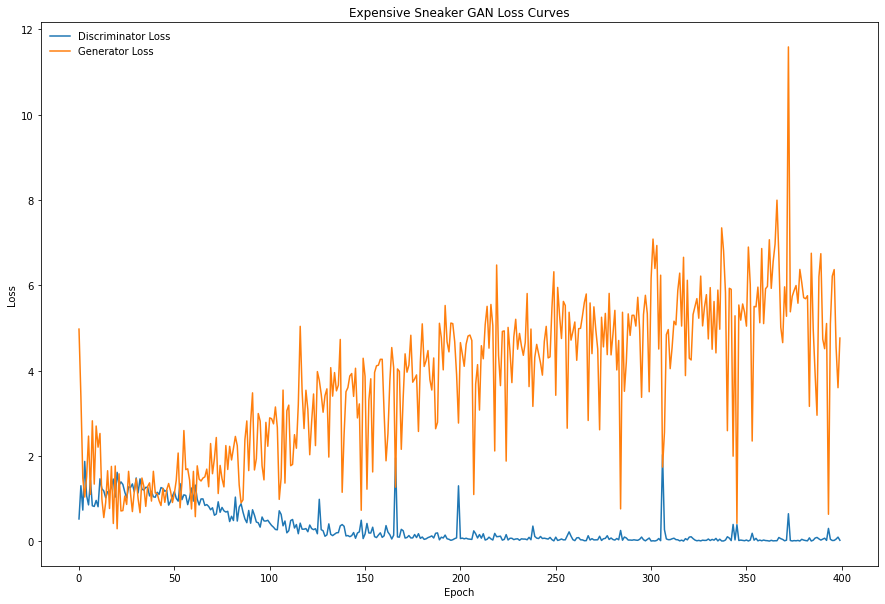

In [14]:
plt.figure(figsize=(15, 10))
plt.plot(d_loss, label="Discriminator Loss")
plt.plot(g_loss, label="Generator Loss")
plt.title('Expensive Sneaker GAN Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(frameon=False);